# Анализ продаж компьютерных игр для определения рекламной стратегии

Для интернет-магазина «Стримчик», который продаёт по всему миру компьютерные игры, нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).

**Цель проекта** - сформировать прогноз продаж, чтобы сделать ставку на потенциально популярные игры у пользователей, и спланировать рекламные компании на 2017 год.

## План работы

* Предобработка данных
* Дополнительные расчеты и добавление результатов в таблицу
* Исследовательский анализ данных
* Составление портрета пользователя каждого региона
* Проверка гипотез
* Общий вывод

## Изучение данных из файлов

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
# чтение файла с данными

data = pd.read_csv('games.csv')

data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [3]:
data.info() # получение общей информации о данных в таблице data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Вывод

В каждой строке таблицы — данные об игре.

Предварительно можно утверждать, что данных достаточно. Но встречаются пропуски в данных. Чтобы двигаться дальше, нужно устранить проблемы в данных.

## Предобработка данных

### Изменение наименований столбцов

In [4]:
# приведение наименований столбцов к нижнему регистру

data.columns = data.columns.str.lower()

### Заполнение пропусков

In [5]:
data.isna().sum() # определение количества пропущенных значений

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Обнаружены пропущенные значения в столбцах: 'name', 'year_of_release', 'genre', 'critic_score' и 'user_score', 'rating'.   
Очень много пропущенных значений в оценках критиков (51%), пользователей (55%) и рейтинге (40%).

В столбцах: 'name' и 'genre' всего по 2 пропущенных значения, которые относятся к одним и тем же строкам. Но т.к. в этих строках есть продажи, указана платформа и год выпуска, то не будем их удалять.  

Скорее всего пропущенные значения появились из-за того, что данные подтягивались из разных источников, и часть данных просто могла некорректно выгрузиться.

Все пропущенные значения во всех столбцах заменим на нереальное значение 99999.

In [6]:
data = data.fillna(99999)

В столбце 'user_score' присутствует значение 'tbd', что означает 'to be determined', т.е. оценка пользователя еще не определена (либо не игра не оценивалась, либо только вышла). Для удобства изменения типа данных этого столбца заменим 'tbd' на нереальное значение 9999999999.

In [7]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = 99999

In [8]:
data.groupby('rating')['rating'].count() / data['rating'].count() * 100 # проверяем значения колонки 'rating'

rating
99999    40.478612
AO        0.005983
E        23.870775
E10+      8.495363
EC        0.047861
K-A       0.017948
M         9.350882
RP        0.017948
T        17.714628
Name: rating, dtype: float64

В столбце 'rating' встречаются редкие значения. Заменим их на более распространенные (RP - рейтинг ожидается - заменяем на 99999). Значения EC (для всех с 3 лет) и AO (18+) оставляем без замены, т.к. это текущий общепринятый рейтинг ESRB и, скорее всего, игры с таким рейтингом просто редко покупают.

In [9]:
data.loc[data['rating'] == 'K-A', 'rating'] = 'E'
data.loc[data['rating'] == 'RP', 'rating'] = 99999

### Изменение типов данных

В некоторых столбцах необходимо заменить типы данных для удобства расчетов. В столбцах 'year_of_release', 'critic_score' вещественный тип на целочисленный, а в столбце 'user_score' строковый тип на вещественный.

In [10]:
# заменяем вещественный тип на целочисленный

data[['year_of_release', 'critic_score']] = data[['year_of_release', 'critic_score']].astype(int)

In [11]:
# заменяем строковый тип на вещественный

data['user_score'] = data['user_score'].astype(float)

### Расчет суммарных продаж

In [12]:
# считаем суммарные продажи во всех регионах

data['sales_total'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

## Исследовательский анализ данных

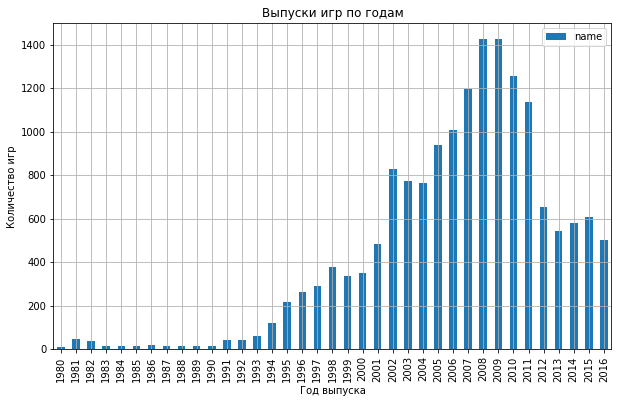

In [13]:
# считаем, сколько игр выпускалось в разные годы

(
    data.pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'count')
    .query('year_of_release != 99999').plot(y='name', kind='bar', figsize=(10,6), grid=True, title='Выпуски игр по годам')
)
plt.xlabel('Год выпуска')
plt.ylabel('Количество игр')
plt.show()

Наибольшее количество игр выпускалось в 2007-2011 годах. После 2011 года пошел резкий спад. Резкий рост был в 2002 году, а до этого в 1994 году (количество выпускаемых игр увеличилось в 2 раза по сравнению с 1993 годом).

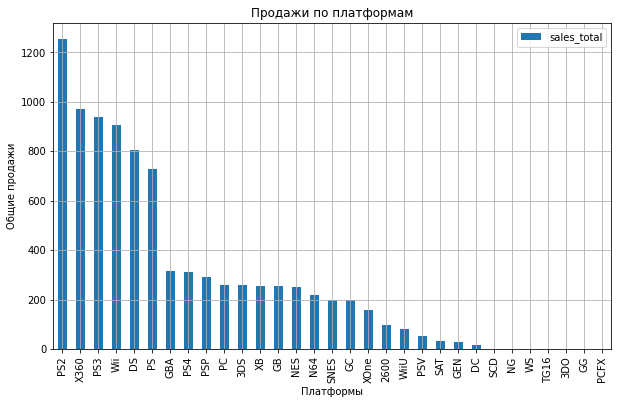

In [14]:
# считаем, как менялись продажи по платформам

(
    data.pivot_table(index = 'platform', values = 'sales_total', aggfunc = 'sum')
    .sort_values(by='sales_total', ascending=False)
    .plot(y='sales_total', kind='bar', figsize=(10,6), grid=True, title='Продажи по платформам')
)
plt.xlabel('Платформы')
plt.ylabel('Общие продажи')
plt.show()

Наибольшие продажи у платформ 'PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS'. Построим распределения по годам у этих платформ.

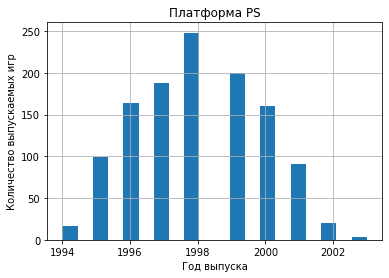

In [15]:
data.query('(platform == "PS") & (year_of_release != 99999)').hist('year_of_release', bins=20)
plt.title('Платформа PS')
plt.xlabel('Год выпуска')
plt.ylabel('Количество выпускаемых игр')
plt.show()

Релиз платформы PS произошел в конце 1994 года, и в следующем 1995 году резко выросло количество выпускаемых игр (что лигично, т.к. данные берутся за целый 1995 год, а в 1994 году только за месяц). Пик приходится на 1998 год, а с выпуском PS2 в конце 2000 года (в Японии раньше) пошло резкое снижение. PS была снята с производства в 2006 году.

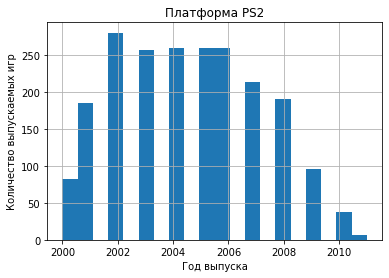

In [16]:
data.query('(platform == "PS2") & (year_of_release != 99999)').hist('year_of_release', bins=20)
plt.title('Платформа PS2')
plt.xlabel('Год выпуска')
plt.ylabel('Количество выпускаемых игр')
plt.show()

У платформы PS2 количество выпущенных игр было стабильно выше 250 с 2002 и вплоть до 2006 года, затем пошло падение, и после 2011 года выпусков уже не было совсем. В 2006 году вышла новая платформа PS3. Логично, что по прошествии 5 лет перестали выпускать игры под старую платформу, т.к. их уже купили все, кому нужно было. На стыке 2012-2013 годов PS2 была снята с производства.

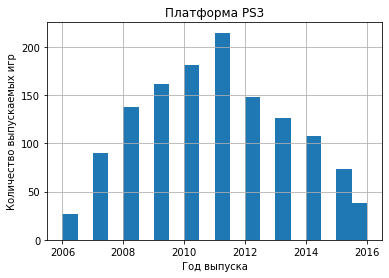

In [17]:
data.query('(platform == "PS3") & (year_of_release != 99999)').hist('year_of_release', bins=20)
plt.title('Платформа PS3')
plt.xlabel('Год выпуска')
plt.ylabel('Количество выпускаемых игр')
plt.show()

Релиз платформы PS3 состоялся в 2006 году, как раз именно в этом году началось снижение количества выпущенных игр для платформы PS2. С каждым годом количество игр росло, и пик приходится на 2011 год, когда перестали выпускать игры для PS2. Затем произошло  резкое снижение, которое продолжилось и дальше. В начале 2017 года PS3 была снята с производства.
В 2013 году была выпущена новая версия PS4, но резкого снижения количества выпущенных игр не наблюдается. Снижение после пика скорее плавное.

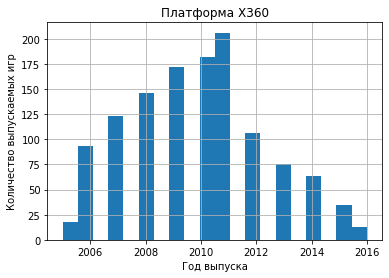

In [18]:
data.query('(platform == "X360") & (year_of_release != 99999)').hist('year_of_release', bins=20)
plt.title('Платформа X360')
plt.xlabel('Год выпуска')
plt.ylabel('Количество выпускаемых игр')
plt.show()

Релиз платформы состоялся в конце 2005 года, поэтому виден такой рост количества выпускаемых игр в 2006 году по сравнению с 2005. Пик, так же как и у PS3, приходится на 2011 год. Затем произошло резкое падение. В 2016 году платформа была снята с производства.

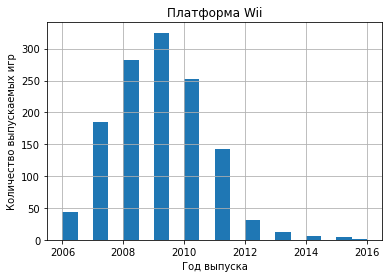

In [19]:
data.query('(platform == "Wii") & (year_of_release != 99999)').hist('year_of_release', bins=20)
plt.title('Платформа Wii')
plt.xlabel('Год выпуска')
plt.ylabel('Количество выпускаемых игр')
plt.show()

Релиз платформы состоялся в конце 2006 года, поэтому виден такой рост количества выпускаемых игр в 2007 году по сравнению с 2006. Пик приходится на 2009 год. Затем произошло некоторое падение в 2010 году и резкое в 2011. В 2013 году прекращена поддержка, но, тем не менее, некоторые игры продолжали выпускаться для этой платформы.

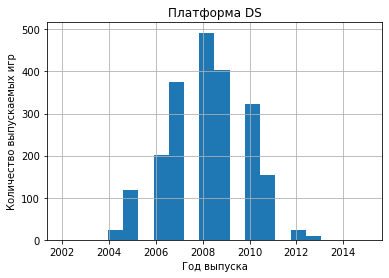

In [20]:
data.query('(platform == "DS") & (year_of_release != 99999)').hist('year_of_release', bins=20, range=(2002,2015))
plt.title('Платформа DS')
plt.xlabel('Год выпуска')
plt.ylabel('Количество выпускаемых игр')
plt.show()

Релиз платформы состоялся в конце 2004 - начале 2005 годах. Резко возросло количество выпускаемых игр в 2007 году по сравнению с 2006. Пик приходится на 2009 год. Затем пошло снижение. У платформы выпускались обновления под тем же названием, поэтому резкие скачки скорее связаны именно с этими обновлениями. В 2011 году вышла новая платформа 3DS, поэтому выпуск новых игр для платформы DS резко сократился.

#### Общий вывод по графикам
У платформ, которые выпустились в 2004-2006 годах видно, что после 2011 года пошел резкий спад количества выпускаемых игр. Скорее всего это связано с экономическим кризисом, который начался в 2008 году. К 2011 году завершили разработки уже начатых игр, а новые разработки не торопились начинать.
Средний срок продаж платформы (с момента выпуска до снятия с производства) - 9-11 лет. Но у Nintendo срок жизни платформы меньше - 7-9 лет. При этом рост происходит в первые 5 лет продаж.

На основании 2х анализов возьмем срез данных, начиная с 2012 года, т.к. пошел спад выпускаемых игр, и анализ будет более актуальным, если брать платформы, основные продажи которых приходится на актуальный период.

In [21]:
data_new = pd.DataFrame(data.query('(year_of_release != 99999) & (year_of_release >= 2012)'))

In [22]:
# определяем, какие платформы лидируют по продажам, растут или падают

data_platform = pd.DataFrame(data_new.pivot_table(index = 'year_of_release', columns = 'platform', values = 'sales_total', aggfunc = 'sum')).fillna(0)
data_platform.loc['Total'] = data_platform.sum()
data_platform

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012,51.36,11.01,23.22,107.36,0.00,7.69,16.19,21.71,17.56,99.74,0.00
2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,0.00,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,0.00,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,0.00,5.25,3.60,69.25,0.00,4.25,0.18,4.60,1.52,26.15
Total,194.61,12.55,62.65,288.79,314.14,11.19,49.18,35.37,82.19,236.54,159.32


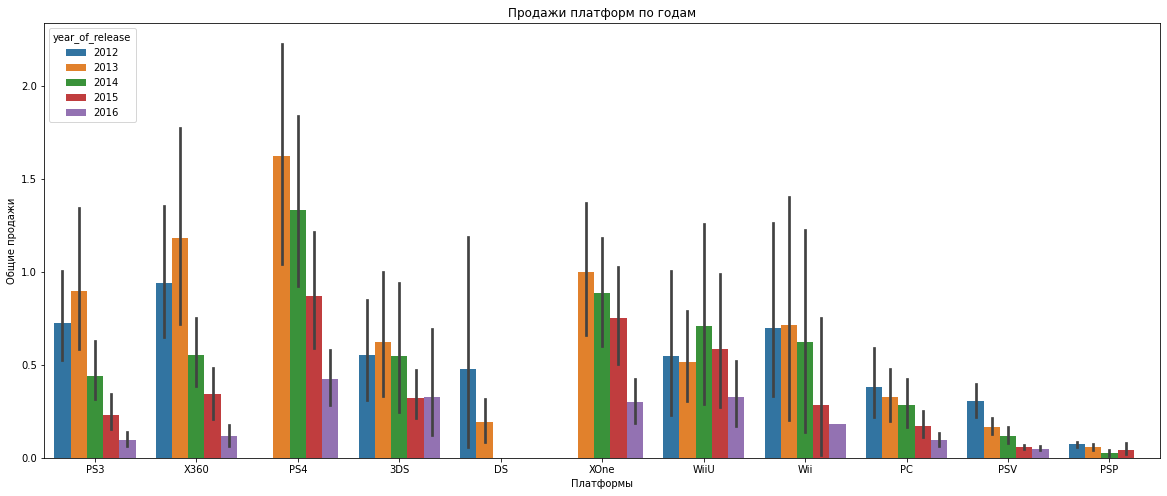

In [23]:
sns.barplot(x='platform',  y='sales_total', data=data_new, hue = 'year_of_release').figure.set_size_inches(20,8)
plt.title('Продажи платформ по годам')
plt.xlabel('Платформы')
plt.ylabel('Общие продажи')
plt.show()

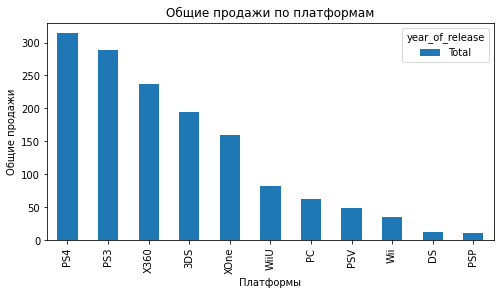

In [24]:
# суммарные продажи по платформам

(
    data_platform.query('year_of_release == "Total"').T
    .sort_values(by='Total', ascending=False)
    .plot(kind='bar', figsize=(8,4))
)
plt.title('Общие продажи по платформам')
plt.xlabel('Платформы')
plt.ylabel('Общие продажи')
plt.show()

Из последнего графика (по суммарным продажам игр для каждой платформы) видно, что наиболее прибыльными платформами являются 3DS, PS3, PS4, X360, XOne.  
Продажи всех платформ падают, пик у всех, кроме WiiU, приходится на 2013 год (из выбранного периода), затем спад. У PS3, 3DS и X360, по факту, пик пришелся на более ранний период, который не вошел в выбранный, и резкий спад пошел после 2011 года (это видно на гистограммах выше) - эти платформы были выпущены раньше, чем PS4 и XOne, хотя уровень продаж все еще высокий.

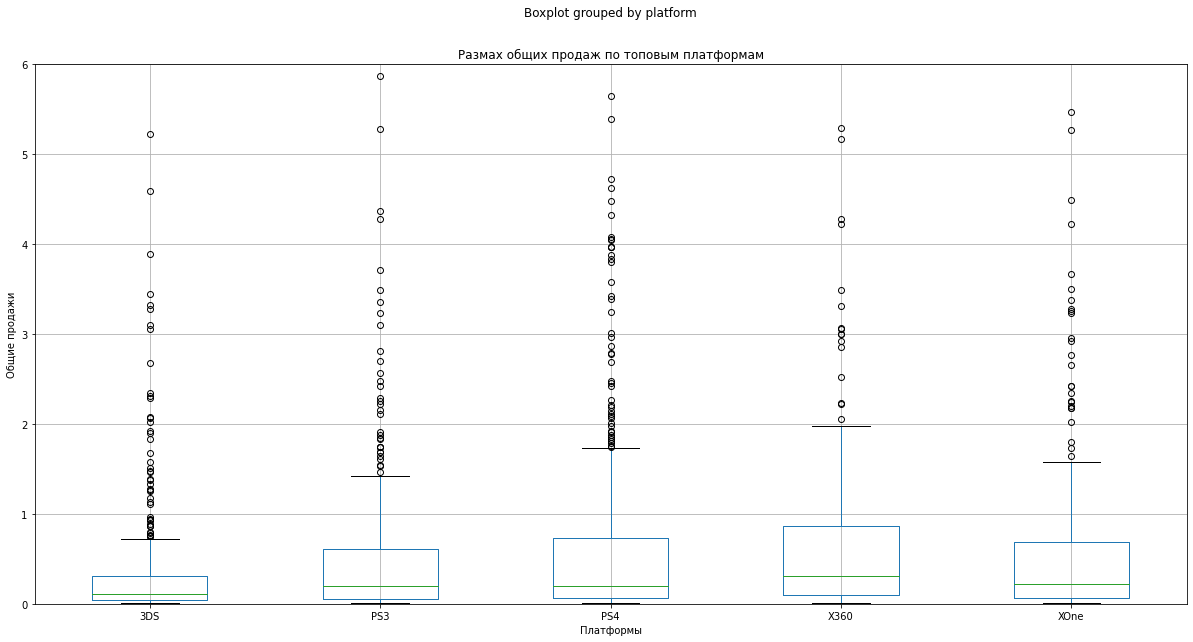

In [25]:
# строим график «ящик с усами» по глобальным продажам игр в разбивке по топовым платформам

(
    data_new.query('platform in ["3DS", "PS3", "PS4", "X360", "XOne"]')
    .boxplot('sales_total', by='platform', figsize=(20, 10)).set_ylim(0,6)
)
plt.title('Размах общих продаж по топовым платформам')
plt.xlabel('Платформы')
plt.ylabel('Общие продажи')
plt.show()

Из графика видно, что у платформ PS3, PS4, XOne почти одинаковая медиана: 0.2-0.22 млн проданных копий. У X360 медиана 0.31 млн, а у 3DS 0.11 млн. По максимальному значению усов топовые платформы (кроме 3DS) находятся между 1-2 млн копий.

In [26]:
# определяем влияние отзывов пользователей и критиков на продажи внутри одной популярной платформы - PS4

# определяем корреляцию
(
    print('Корреляция продаж и оценки критиков:', 
          data_new.query('(platform == "PS4") & (critic_score != 99999)')['sales_total']
          .corr(data_new.query('(platform == "PS4") & (critic_score != 99999)')['critic_score']))
)
(
    print('Корреляция продаж и оценки пользователей:', 
          data_new.query('(platform == "PS4") & (user_score != 99999)')['sales_total']
          .corr(data_new.query('(platform == "PS4") & (user_score != 99999)')['user_score']))
)

Корреляция продаж и оценки критиков: 0.406567902061781
Корреляция продаж и оценки пользователей: -0.031957110204556376


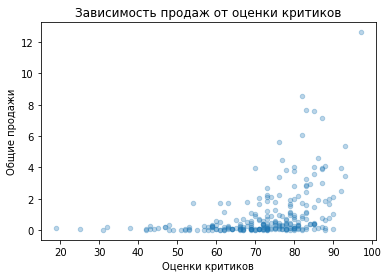

In [27]:
# строим диаграмму рассеяния для зависимости продаж от оценки критиков

(
    data_new.query('(platform == "PS4") & (critic_score != 99999)')
    .plot(x='critic_score', y='sales_total', kind='scatter', alpha=0.3)
)
plt.title('Зависимость продаж от оценки критиков')
plt.xlabel('Оценки критиков')
plt.ylabel('Общие продажи')
plt.show()

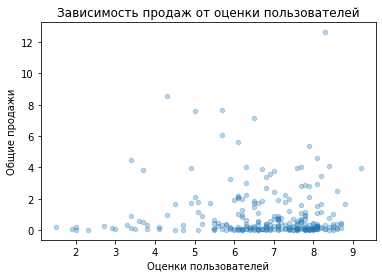

In [28]:
# строим диаграмму рассеяния для зависимости продаж от оценки пользователей

(
    data_new.query('(platform == "PS4") & (user_score != 99999)')
    .plot(x='user_score', y='sales_total', kind='scatter', alpha=0.3)
)
plt.title('Зависимость продаж от оценки пользователей')
plt.xlabel('Оценки пользователей')
plt.ylabel('Общие продажи')
plt.show()

Из коэффициентов корреляции и графиков видно, что продажи PS4 слабо зависят от оценок критиков и не зависят от оценок пользователей. Но, по факту, обычно продажа игр еще зависит от цены самой игры и от того, насколько сильно ждут ее выхода пользователи. Например, если игра недорогая и короткая по времени прохождения (просто провести несколько вечеров за игрой), то пользователь может и смотреть на оценки. А если игра известная, дорогая, с долгим временем прохождения, то больше смотрят на оценки (как критиков, так  других пользователей).

Корреляция продаж и оценки критиков 3DS : 0.32080286953607845


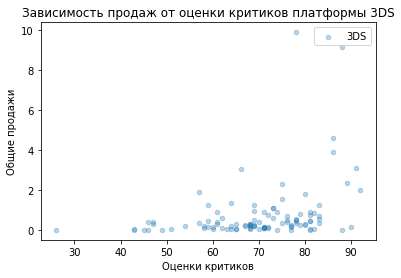

Корреляция продаж и оценки пользователей 3DS : 0.19758263411038596


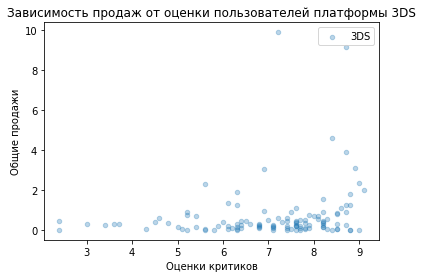

Корреляция продаж и оценки критиков PS3 : 0.3314972592629587


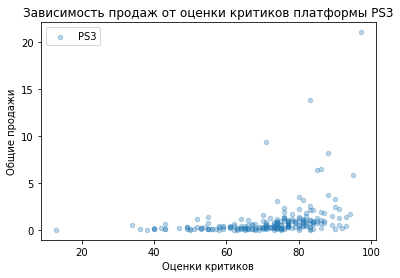

Корреляция продаж и оценки пользователей PS3 : -0.005143522887113828


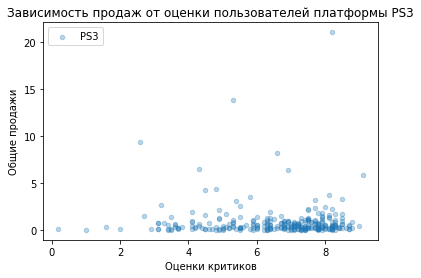

Корреляция продаж и оценки критиков X360 : 0.36057348885073365


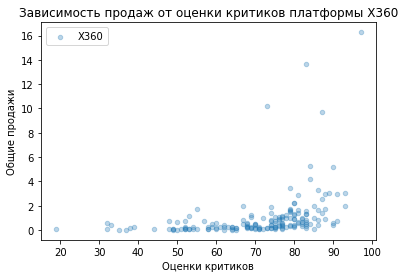

Корреляция продаж и оценки пользователей X360 : 0.0061639786462133256


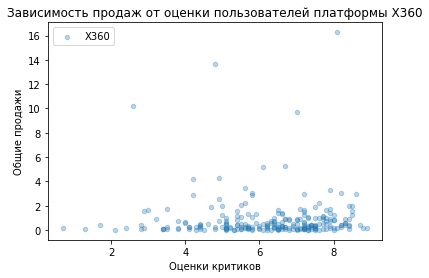

Корреляция продаж и оценки критиков XOne : 0.41699832800840175


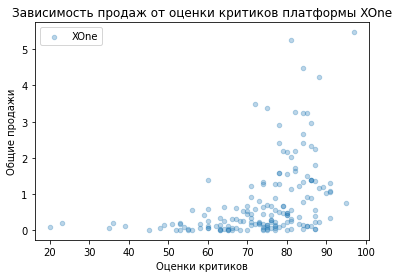

Корреляция продаж и оценки пользователей XOne : -0.06892505328279412


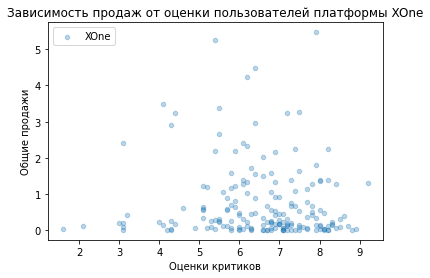

In [29]:
# определяем корреляцию и строим диаграммы для других топовых платформ

other_top_four = ['3DS', 'PS3', 'X360', 'XOne']

for platform in other_top_four:
    (
        print('Корреляция продаж и оценки критиков', platform, ':', 
        data_new.query('(platform == @platform) & (critic_score != 99999)')['sales_total']
        .corr(data_new.query('(critic_score != 99999)')['critic_score']))
    )
    (
        data_new.query('(platform == @platform) & (critic_score != 99999)')
        .plot(x='critic_score', y='sales_total', kind='scatter', alpha=0.3, label=platform)
    )
    plt.title(f'Зависимость продаж от оценки критиков платформы {platform}')
    plt.xlabel('Оценки критиков')
    plt.ylabel('Общие продажи')
    plt.show()
    (
        print('Корреляция продаж и оценки пользователей', platform, ':', 
        data_new.query('(platform == @platform) & (user_score != 99999)')['sales_total']
        .corr(data_new.query('(user_score != 99999)')['user_score']))
    )
    (
        data_new.query('(platform == @platform) & (user_score != 99999)')
        .plot(x='user_score', y='sales_total', kind='scatter', alpha=0.3, label=platform)
    )
    plt.title(f'Зависимость продаж от оценки пользователей платформы {platform}')
    plt.xlabel('Оценки критиков')
    plt.ylabel('Общие продажи')
    plt.show()

По остальным топовым платформам ситуация похожа на ситуацию с платформой PS4: продажи слабо зависят от оценок критиков и не зависят от оценок пользователей. При этом значение корреляции от оценки критиков у всех платформ примерно одинаковое и находится на слабом уровне в диапазоне 0.32-0.42. А корреляция оценок пользователей только у 3DS выбивается из значений '+/-0', и находится на уровне 0.20.

In [30]:
#  считаем средние оценки критиков и пользователей по платформам

(
    round(data_new.query('(critic_score != 99999) & (user_score != 99999)')
    .pivot_table(index='platform', values=['critic_score', 'user_score'], aggfunc='mean'),0)
    .astype(int)
)

,critic_score,user_score
platform,,
3DS,70,7
DS,80,8
PC,76,6
PS3,72,7
PS4,72,7
PSP,74,8
PSV,71,8
Wii,76,7
WiiU,71,7


Таким образом, средние пользовательские рейтинги всех платформ находятся в пределах 6-8 баллов, а оценки критиков - в пределах 70-80 баллов.

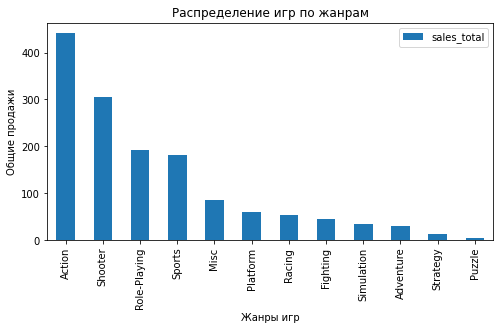

In [31]:
# определяем наиболее прибыльные жанры игр

# считаем распределение игр по жанрам по общим продажам

(
    data_new.pivot_table(index='genre', values='sales_total', aggfunc='sum')
    .sort_values(by='sales_total', ascending=False)
    .plot(kind='bar', figsize=(8,4))
)
plt.title('Распределение игр по жанрам')
plt.xlabel('Жанры игр')
plt.ylabel('Общие продажи')
plt.show()

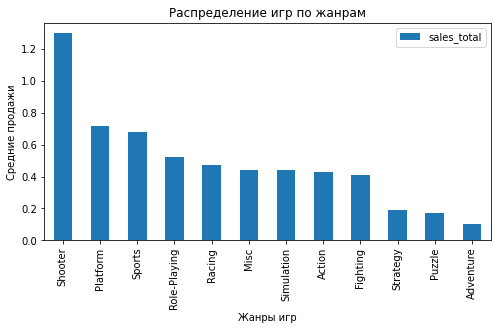

In [32]:
# считаем распределение игр по жанрам по средним продажам

(
    round(data_new.pivot_table(index='genre', values='sales_total'),2)
    .sort_values(by='sales_total', ascending=False)
    .plot(kind='bar', figsize=(8,4))
)
plt.title('Распределение игр по жанрам')
plt.xlabel('Жанры игр')
plt.ylabel('Средние продажи')
plt.show()

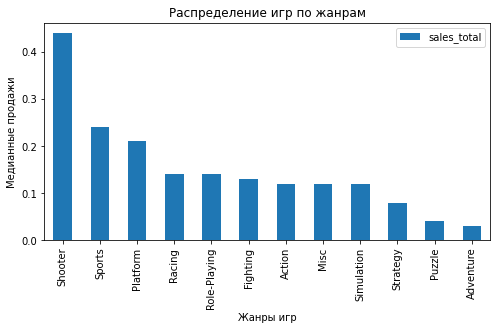

In [33]:
# считаем распределение игр по жанрам по медианным продажам

(
    round(data_new.pivot_table(index='genre', values='sales_total', aggfunc='median'),2)
    .sort_values(by='sales_total', ascending=False)
    .plot(kind='bar', figsize=(8,4))
)
plt.title('Распределение игр по жанрам')
plt.xlabel('Жанры игр')
plt.ylabel('Медианные продажи')
plt.show()

Если смотреть на общие продажи, то наиболее продаваемые жанры - это 'Action', 'Shooter', 'Role-Playing' и 'Sports'. Эти 4 жанра вместе составили 77% от всех продаж. Особенно заметно выделяются продажи жанров 'Action' и 'Shooter' (52% от всех продаж). А среди низких продаж выделяется жанр 'Puzzle'. Жанр 'Action' самый продающийся, потому что название жанра слишком широкое, и почти любую современную игру можно отнести сюда, поэтому сюда попадают многие игры. А жанр 'Puzzle' в большей степени актуален для мобильных телефонов, и разработчики больше зарабатывают на рекламе в этих играх, а не прямыми продажами игры.  

Но если взглянуть на средние и медианные продажи, то картина несколько меняется. Наиболее популярные жанры - это 'Shooter', 'Platform', 'Sports', 'Role-Playing', 'Racing'. При чем 'Shooter' лидирует с большим отрывом. Внизу списка находятся жанры 'Puzzle' и 'Adventure'.
Разница в распределении игр по жанрам в общих продажах и в средних может быть из-за того, что в общие продажи  могут попасть множество мелких игр с низкими продажами.

## Составление портрета пользователя каждого региона

In [34]:
# определяем самые популярные платформы (топ-5) для пользователя каждого региона (NA, EU, JP)

data_new.pivot_table(index='platform', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')

,eu_sales,jp_sales,na_sales
platform,,,
3DS,42.64,87.79,55.31
DS,3.53,3.72,4.59
PC,37.76,0.00,19.12
PS3,106.86,35.29,103.38
PS4,141.09,15.96,108.74
PSP,0.42,10.47,0.13
PSV,11.36,21.04,10.98
Wii,11.92,3.39,17.45
WiiU,25.13,13.01,38.10


Топ-5 самых популярных платформ для каждого региона (в порядке убывания популярности):  
NA - Северная Америка: X360, PS4, PS3, XOne, 3DS  
EU - Европа: PS4, PS3, X360, XOne, 3DS  
JP - Япония: 3DS, PS3, PSV, PS4, WiiU 

В Северной Америке популярны как американские, так и японские платформы, но Microsoft X360 лидирует с большим отрывом.
В Европе также популярны как американские, так и японские платформы, но большей популярностью пользуются японские платформы Sony PS4, PS3 - у них большой отрыв от расположившегося на 3 месте X360.
В Японии в топ-5 попали только японские платформы, при чем Nintendo более популярен, чем Sony - слишком большой отрыв 1го места от 2го. Наибольшую популярность имеет портативная платформа 3DS - это может быть связано с тем, что японцы достаточно много времени проводят на работе и в транспорте на работу и домой. Также в топ-5 попала еще одна портативная платформа PSV от Sony.

In [35]:
# определяем самые популярные жанры (топ-5) для пользователя каждого региона (NA, EU, JP)

data_new.pivot_table(index='genre', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')

,eu_sales,jp_sales,na_sales
genre,,,
Action,159.34,52.80,177.84
Adventure,9.46,8.24,8.92
Fighting,10.79,9.44,19.79
Misc,26.32,12.86,38.19
Platform,21.41,8.63,25.38
Puzzle,1.40,2.14,1.13
Racing,27.29,2.50,17.22
Role-Playing,48.53,65.44,64.00
Shooter,113.47,9.23,144.77


Топ-5 самых популярных жанров для каждого региона (в порядке убывания популярности, не принимая во внимание жанр Misc - то,что не вошло в основные жанры):  
NA - Северная Америка: Action, Shooter, Sports, Role-Playing, Platform  
EU - Европа: Action, Shooter, Sports, Role-Playing, Racing  
JP - Япония: Role-Playing, Action, Simulation, Fighting, Shooter  

Первые четыре жанра (Action, Shooter, Sports, Role-Playing) полностью совпадают в Америке и Европе по распределению мест, то есть у пользователей из этих частей света очень схожие предпочтения. А в Японии 3 жанра (Role-Playing, Action, Shooter) совпадают с теми, что популярны в Америке и Европе, но находятся они на других позициях в списке. Например, если в Америке и Европе Role-Playing на 4 месте, то в Японии это самый популярный жанр, а Shooter, находящийся в Америке и Европе на 2 месте, в Японии опустился на 5 место.

In [36]:
# определяем, влияет ли рейтинг ESRB на продажи в отдельном регионе

data_new.pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')

,eu_sales,jp_sales,na_sales
rating,,,
99999,91.50,108.84,103.31
E,113.03,28.33,114.37
E10+,55.37,8.19,75.70
M,193.96,21.20,231.57
T,52.96,26.02,66.02


Распределение рейтинга для каждого региона (в порядке убывания популярности):  
NA - Северная Америка: M, E, без рейтинга, E10+, T  
EU - Европа: M, E, без рейтинга, E10+, T  
JP - Япония: без рейтинга, E, T, M, E10+  

E - для всех от 6 лет,  E10+ - для всех от 10 лет, T - подросткам от 13 лет, M - для взрослых от 17 лет.

Видно, что рейтинг влияет на продажи, при чем в Америке и Европе полностью совпадает распределение мест рейтинга. Самыми популярными являются игры для взрослых (рейтинг M) - они лидируют с больим отрывом от 2го места - игры для всех (рейтинг E). Также возможно, что в Америке и Европе рейтинг игры более высокий по возрасту, нежели в Японии (например, в Японии рейтинг игры T, а в Америке и Европе - рейтинг M).

В Японии же самыми популярными являются игры без рейтинга, и в этой стране нет такого сильного разрыва между жанрами E, T, M, то есть, на первый взгляд, тут жанр в меньшей степени влияет на продажи, нежели в Америке и Европе. Но в Японии существует своя организация, которая выставляет рейтинги для игр, выпущенных в стране. Поэтому вполне возможно, что всем играм, у которых в таблице пропущен рейтинг, просто не присвоен рейтинг ESRB, а присвоен рейтинг местной CERO. Также в Японии наиболее популярны портативные платформы, а для них нельзя сделать игры, где были бы качественно отрисованы все жестокие сцены и т.д., поэтому, возможно, популярность игр 17+ ниже. 

### Общие выводы по портрету пользователя

В Америке и Европе предпочтения пользователей очень схожи, если не сказать одинаковы - у них почти одинаково популярны как американские, так и японские платформы, предпочитают жанры Action, Shooter, Sports, Role-Playing и основные продажи идут от игр для взрослых с рейтингом M (на втором месте игры для всех от 6 лет с рейтингом E).   
В Японии предпочтения пользователей несколько иные - в топ-5 вошли только японские платформы, при чем на 1 и на 3 местах портативные, предпочитают жанры Role-Playing, Action, Simulation, Fighting, Shooter, и почти нет зависимости от рейтинга - игры с рейтингом E и T одинаково полулярны, а игры с рейтингом M не сильно отстают. Но наибольшие продажи идут от игр без рейтинга ESRB. Т.к. неизвестно, есть ли у этих игр рейтинг местной организации, то по Японии невозможно четко определить, если ли зависимость продаж от рейтинга игры.

## Проверка гипотез

### Гипотеза 1

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.  

Критический уровень статистической значимости примем 0.05.

In [37]:
xone = pd.Series(data_new.query('(platform == "XOne") & (user_score != 99999)')['user_score']) # выделяем столбец с оценками пользователей для платформы Xbox One
pc = pd.Series(data.query('(platform == "PC") & (user_score != 99999)')['user_score']) # выделяем столбец с оценками пользователей для платформы PC

print('Средний пользовательский рейтинг платформы XOne:', xone.mean().astype(int))
print('Средний пользовательский рейтинг платформы PC:', pc.mean().astype(int))
      
alpha = .05
      
results = st.ttest_ind(xone, pc)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средний пользовательский рейтинг платформы XOne: 6
Средний пользовательский рейтинг платформы PC: 7
p-значение: 1.3896435533548819e-05
Отвергаем нулевую гипотезу


Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.  
Альтернативная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC не равны.  
Для сравнения средних двух генеральных совокупностей используются методы st.ttest_ind и pvalue (показывает вероятность ошибки, если отвергнем нулевую гипотезу).  

По итогам теста нулевая гипотеза отвергается. Посчитав среднее выборок по двум платформам видим, что средние пользовательские оценки различаются - для платформы XOne средняя оценка ниже, чем для PC.

### Гипотеза 2

Средние пользовательские рейтинги жанров Action и Sports разные.  

Критический уровень статистической значимости примем 0.05.

In [38]:
action = pd.Series(data_new.query('(genre == "Action") & (user_score != 99999)')['user_score']) # выделяем столбец с оценками пользователей для жанра Action
sports = pd.Series(data.query('(genre == "Sports") & (user_score != 99999)')['user_score']) # выделяем столбец с оценками пользователей для жанра Sports

print('Средний пользовательский рейтинг жанра Action:', action.mean().astype(int))
print('Средний пользовательский рейтинг жанра Sports:', sports.mean().astype(int))
      
alpha = .05
      
results = st.ttest_ind(action, sports)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средний пользовательский рейтинг жанра Action: 6
Средний пользовательский рейтинг жанра Sports: 6
p-значение: 0.09588832822398892
Не получилось отвергнуть нулевую гипотезу


Нулевая гипотеза: средние пользовательские рейтинги жанров Action и Sports одинаковые.  
Альтернативная гипотеза: средние пользовательские рейтинги жанров Action и Sports не равны.  
Для сравнения средних двух генеральных совокупностей используются методы st.ttest_ind и pvalue (показывает вероятность ошибки, если отвергнем нулевую гипотезу).  

По итогам теста не получилось отвергнуть нулевую гипотезу. Посчитав среднее выборок по двум жанрам видим, что средние пользовательские оценки одинаковые и равны 6.

## Общий вывод

### Цель проекта:
Выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании на 2017 год.

### Входные данные:
Исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы из открытых источников.

### Предобработка данных:
1. Изменены наименования столбцов:
    1. все столбцы - наименования приведены к нижнему регистру.
2. Заменены отсутствующие данные:
    1. 'name', 'year_of_release', 'genre', 'critic_score' и 'user_score', 'rating' - заменены на 99999;
    2. в столбце 'user_score' - значение 'tbd' заменено на 99999.
2. Изменены типы данных:
    1. 'year_of_release', 'critic_score' - вещественный тип данных изменен на целочисленный;
    2. 'user_score' - строковый тип данных изменен на вещественный.
3. Сделаны дополнительные расчеты:
    1. 'sales_total' - подсчитаны общие продажи по всем регионам.


### Анализ данных
Наиболее популярными платформами за весь период данных являются PS2, X360, PS3, Wii, DS, PS. При этом наибольшее количество игр выпускалось в 2007-2011 годах. До этого резкий рост был в 2002 году, а еще раньше в 1994 году (количество выпускаемых игр увеличилось в 2 раза по сравнению с 1993 годом).  
У платформ, которые выпустились в 2004-2006 годах, пошел резкий спад количества выпускаемых игр после 2011 года. Скорее всего это связано с экономическим кризисом, который начался в 2008 году. К 2011 году завершили разработки уже начатых игр, а новые разработки не торопились начинать.  
Средний срок продаж платформы (с момента выпуска до снятия с производства) - 9-11 лет. Но у Nintendo срок жизни платформы меньше - 7-9 лет. При этом рост происходит в первые 5 лет продаж.   
  
Наиболее прибыльными платформами за актуальный период 2012-2016 годы являются 3DS, PS3, PS4, X360, XOne.
Продажи всех платформ к 2016 году падают, пик у всех приходится на 2013 год (из выбранного периода), затем спад. У PS3, 3DS и X360, по факту, пик пришелся на более ранний период, который не вошел в выбранный, и резкий спад пошел после 2011 года - эти платформы были выпущены раньше, чем PS4 и XOne, хотя уровень продаж все еще был высокий.

Продажи всех топовых платформ слабо зависят от оценок критиков и не зависят от оценок пользователей. Но, по факту, обычно продажа игр еще зависит от цены самой игры и от того, насколько сильно ждут ее выхода пользователи. Например, если игра дешевая и короткая по времени прохождения (просто провести несколько вечеров за игрой), то пользователь может и смотреть на оценки. А если игра известная, дорогая, с долгим временем прохождения, то больше смотрят на оценки (как критиков, так  других пользователей).

Средние пользовательские рейтинги всех платформ находятся в пределах 6-8 баллов, а оценки критиков - в пределах 70-80 баллов.

Наиболее продаваемые жанры (по общим продажам) - это 'Action', 'Shooter', 'Role-Playing' и 'Sports'. Эти 4 жанра вместе составили 77% от всех продаж. Особенно заметно выделяются продажи жанров 'Action' и 'Shooter' (52% от всех продаж). А среди низких продаж выделяется жанр 'Puzzle'. Жанр 'Action' самый продающийся, потому что название жанра слишком широкое, и почти любую современную игру можно отнести сюда, поэтому сюда попадают многие игры. А жанр 'Puzzle' в большей степени актуален для мобильных телефонов, и разработчики больше зарабатывают на рекламе в этих играх, а не прямыми продажами игры.   
Но если взглянуть на средние и медианные продажи, то картина несколько меняется. Наиболее популярные жанры - это 'Shooter', 'Platform', 'Sports', 'Role-Playing', 'Racing'. При чем 'Shooter' лидирует с большим отрывом. Внизу списка находятся жанры 'Puzzle' и 'Adventure'.   
Разница в распределении игр по жанрам в общих продажах и в средних может быть из-за того, что в общие продажи  могут попасть множество мелких игр с низкими продажами.

### Портрет пользователя по каждому региону
**Топ-5 самых популярных платформ для каждого региона** (в порядке убывания популярности):
NA - Северная Америка: X360, PS4, PS3, XOne, 3DS
EU - Европа: PS4, PS3, X360, XOne, 3DS
JP - Япония: 3DS, PS3, PSV, PS4, WiiU

В Северной Америке популярны как американские, так и японские платформы, но Microsoft X360 лидирует с большим отрывом. В Европе также популярны как американские, так и японские платформы, но большей популярностью пользуются японские платформы Sony PS4, PS3 - у них большой отрыв от расположившегося на 3 месте X360. В Японии в топ-5 попали только японские платформы, при чем Nintendo более популярен, чем Sony - слишком большой отрыв 1го места от 2го. Наибольшую популярность имеет портативная платформа 3DS - это может быть связано с тем, что японцы достаточно много времени проводят на работе и в транспорте на работу и домой. Также в топ-5 попала еще одна портативная платформа PSV от Sony.

**Топ-5 самых популярных жанров для каждого региона** (в порядке убывания популярности, не принимая во внимание жанр Misc - то,что не вошло в основные жанры):
NA - Северная Америка: Action, Shooter, Sports, Role-Playing, Platform
EU - Европа: Action, Shooter, Sports, Role-Playing, Racing
JP - Япония: Role-Playing, Action, Simulation, Fighting, Shooter

Первые четыре жанра (Action, Shooter, Sports, Role-Playing) полностью совпадают в Америке и Европе по распределению мест, то есть у пользователей из этих частей света очень схожие предпочтения. А в Японии 3 жанра (Role-Playing, Action, Shooter) совпадают с теми, что популярны в Америке и Европе, но находятся они на других позициях в списке. Например, если в Америке и Европе Role-Playing на 4 месте, то в Японии это самый популярный жанр, а Shooter, находящийся в Америке и Европе на 2 месте, в Японии опустился на 5 место.

**Распределение рейтинга для каждого региона** (в порядке убывания популярности):
NA - Северная Америка: M, E, без рейтинга, E10+, T
EU - Европа: M, E, без рейтинга, E10+, T
JP - Япония: без рейтинга, E, T, M, E10+

E - для всех от 6 лет, E10+ - для всех от 10 лет, T - подросткам от 13 лет, M - для взрослых от 17 лет.

Видно, что рейтинг влияет на продажи, при чем в Америке и Европе полностью совпадает распределение мест рейтинга. Самыми популярными являются игры для взрослых (рейтинг M) - они лидируют с больим отрывом от 2го места - игры для всех (рейтинг E). Также возможно, что в Америке и Европе рейтинг игры более высокий по возрасту, нежели в Японии (например, в Японии рейтинг игры T, а в Америке и Европе - рейтинг M).   
В Японии же самыми популярными являются игры без рейтинга, и в этой стране нет такого сильного разрыва между играми с рейтингом E, T, M, то есть, на первый взгляд, тут рейтинг в меньшей степени влияет на продажи, нежели в Америке и Европе. Но в Японии существует своя организация, которая выставляет рейтинги для игр, выпущенных в стране. Поэтому вполне возможно, что всем играм, у которых в таблице пропущен рейтинг, просто не присвоен рейтинг ESRB, а присвоен рейтинг местной CERO. Также в Японии наиболее популярны портативные платформы, а для них нельзя сделать игры, где были бы качественно отрисованы все жестокие сцены и т.д., поэтому, возможно, популярность игр 17+ ниже. 

Таким образом, в Америке и Европе предпочтения пользователей очень схожи, если не сказать одинаковы - у них почти одинаково популярны как американские, так и японские платформы, предпочитают жанры Action, Shooter, Sports, Role-Playing и основные продажи идут от игр для взрослых с рейтингом M (на втором месте игры для всех от 6 лет с рейтингом E).
В Японии предпочтения пользователей несколько иные - в топ-5 вошли только японские платформы, при чем на 1 и на 3 местах портативные, предпочитают жанры Role-Playing, Action, Simulation, Fighting, Shooter, и почти нет зависимости от рейтинга - игры с рейтингом E и T одинаково полулярны, а игры с рейтингом M не сильно отстают. Но наибольшие продажи идут от игр без рейтинга ESRB. Т.к. неизвестно, есть ли у этих игр рейтинг местной организации, то по Японии невозможно четко определить, если ли зависимость продаж от рейтинга игры.